In [200]:
from Decoder_RNN import DecoderRNN
from Encoder_CNN import EncoderCNN
import torch.nn as nn
import torch
import torch.optim as optim
import kagglehub
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os
import spacy
import torchvision.transforms.v2 as transforms
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [201]:
# Download latest version
#path = kagglehub.dataset_download("adityajn105/flickr8k")

#print("Path to dataset files:", path)
#/home/esun/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1

In [202]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [203]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [204]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [205]:
spacy_eng = spacy.load("en_core_web_sm")

In [206]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [207]:
root="Flickr8k/Images/"
captions="Flickr8k/captions.txt"
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
dataset=FlickrDataset(root,captions,transform)
pad_idx=dataset.vocab.stoi["<PAD>"]
loader=DataLoader(dataset,batch_size=32,num_workers=2,shuffle=True,pin_memory=True,collate_fn=MyCollate(pad_idx))

/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [208]:
for idx,(imgs,captions) in enumerate(loader):
    print(imgs)
    print(captions)
    break

tensor([[[[-0.3098, -0.3098, -0.3020,  ...,  0.4353,  0.4275,  0.4196],
          [-0.2941, -0.2941, -0.2941,  ...,  0.4039,  0.3961,  0.3882],
          [-0.2784, -0.2784, -0.2784,  ...,  0.3725,  0.3647,  0.3569],
          ...,
          [-0.8588, -0.8588, -0.8667,  ..., -0.5843, -0.5765, -0.5765],
          [-0.8588, -0.8667, -0.8745,  ..., -0.5922, -0.5922, -0.5922],
          [-0.8510, -0.8588, -0.8667,  ..., -0.6157, -0.6235, -0.6235]],

         [[-0.3804, -0.3804, -0.3725,  ...,  0.2078,  0.2000,  0.2000],
          [-0.3725, -0.3725, -0.3647,  ...,  0.1922,  0.1765,  0.1686],
          [-0.3569, -0.3569, -0.3490,  ...,  0.1608,  0.1529,  0.1451],
          ...,
          [-0.8667, -0.8667, -0.8667,  ..., -0.6784, -0.6863, -0.6784],
          [-0.8667, -0.8667, -0.8745,  ..., -0.6863, -0.6941, -0.6941],
          [-0.8588, -0.8588, -0.8667,  ..., -0.7020, -0.7098, -0.7176]],

         [[-0.5059, -0.5059, -0.5137,  ..., -0.2078, -0.2078, -0.2078],
          [-0.4980, -0.4980, -

In [209]:
def print_examples(model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(
        0
    )
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(model.caption_image(test_img1.to(device), dataset.vocab))
    )
    test_img2 = transform(
        Image.open("test_examples/child.jpg").convert("RGB")
    ).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
    )
    test_img3 = transform(Image.open("test_examples/bus.png").convert("RGB")).unsqueeze(
        0
    )
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(model.caption_image(test_img3.to(device), dataset.vocab))
    )
    test_img4 = transform(
        Image.open("test_examples/boat.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(model.caption_image(test_img4.to(device), dataset.vocab))
    )
    test_img5 = transform(
        Image.open("test_examples/horse.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(model.caption_image(test_img5.to(device), dataset.vocab))
    )
    model.train()

In [210]:
#torch.backends.cudnn.benchmark = True
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load_model = False
#save_model = False
#train_CNN = False
## Hyperparameters
#embed_size = 256
#hidden_size = 256
#vocab_size = len(dataset.vocab)
#num_layers = 1
#learning_rate = 3e-4
#num_epochs = 128
#step = 0
#
#
#
## initialize model, loss etc
#model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
#criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#
#
#
#
#
#model.train()
#
#
#for epoch in range(num_epochs):
#    #print(epoch)
#    #print_examples(model, device, dataset)
#    
#    for idx, (imgs, captions) in tqdm(
#        enumerate(loader), total=len(loader), leave=False
#    ):
#        imgs = imgs.to(device)
#        captions = captions.to(device)
#        outputs = model(imgs, captions[:-1])
#        loss = criterion(
#            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
#        )
#        step += 1
#        #uncomment below for l2 norm, l1 norm put p.pow(1)
#        #l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#        #loss += 0.00001 * l2_norm
#        optimizer.zero_grad()
#        loss.backward(loss)
#        optimizer.step()

In [211]:
#print_examples(model,device,dataset)

In [212]:
#torch.save(model.state_dict(), 'model_weights.pth')

In [213]:
#Model Comparison
def load_model(model_name,image_size,augmentation=False):
    transform_list=[transforms.Resize((image_size,image_size)),transforms.ToTensor()]
    if augmentation:
        transform_list+=[transforms.RandomHorizontalFlip(),transforms.RandomRotation(10)]
    
    transform=transforms.Compose(transform_list)
    root="Flickr8k/Images/"
    captions="Flickr8k/captions.txt"
    dataset=FlickrDataset(root,captions,transform)
    dataloader=DataLoader(dataset,batch_size=32,shuffle=False,collate_fn=MyCollate(dataset.vocab.stoi["<PAD>"]))
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    model=CNNtoRNN(embed_size,hidden_size,vocab_size,num_layers)
    model.load_state_dict(torch.load(f'{model_name}.pth',weights_only=True))
    model.eval()
    return model,dataloader
    

In [214]:
def calculate_bleu_score(predictions, references):
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        # pred and ref are already lists of tokens
        score = sentence_bleu([ref], pred)  # BLEU expects a list of references and a hypothesis
        bleu_scores.append(score)
    return np.mean(bleu_scores)


In [215]:
def evaluate_model(model,dataloader,loss_fn,device):
    model.to(device)
    total_loss=0.0
    predictions,references=[],[]
    with torch.no_grad():
        for images,captions in tqdm(dataloader, desc="Evaluating", unit="batch"):
            images=images.to(device)
            captions=captions.to(device)
            
            outputs=model(images,captions[:-1])
            loss=loss_fn(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            total_loss+=loss.item()
            
            vocabulary=dataset.vocab
            
            # Get the predicted word indices
            predicted_tokens = outputs.argmax(dim=-1)  # Get predicted word indices
            for caption in predicted_tokens:
                words = [vocabulary.itos[idx.item()] for idx in caption if idx.item() != vocabulary.stoi['<PAD>']]
                predictions.append(words)

            references.extend([[vocabulary.itos[idx.item()] for idx in caption] for caption in captions[:, 1:].cpu()])

    avg_loss=total_loss/len(dataloader)
    bleu_score=calculate_bleu_score(predictions,references)
    
    return avg_loss,bleu_score
            

In [216]:
def plot_metrics(metrics_df):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(metrics_df['Model'], metrics_df['Loss'], color='red', alpha=0.6, label='Loss')
    ax2 = ax1.twinx()
    ax2.plot(metrics_df['Model'], metrics_df['BLEU Score'], color='blue', marker='o', label='BLEU Score')

    ax1.set_xlabel('Models')
    ax1.set_ylabel('Loss', color='red')
    ax2.set_ylabel('BLEU Score', color='blue')
    plt.title('Model Comparison: Loss vs BLEU Score')

    fig.tight_layout()
    plt.show()

In [217]:
def compare_models(models_info):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_fn=nn.CrossEntropyLoss()
    metrics=defaultdict(list)
    for model_name, config in models_info.items():
        print(f"Evaluating {model_name}...")
        model, dataloader = load_model(model_name, config['image_size'], config['augmentation'])
        loss, bleu = evaluate_model(model, dataloader, loss_fn, device)

        metrics['Model'].append(model_name)
        metrics['Loss'].append(loss)
        metrics['BLEU Score'].append(bleu)

        print(f"Model: {model_name}, Loss: {loss:.4f}, BLEU Score: {bleu:.4f}")

    # Convert metrics to DataFrame for better visualization
    metrics_df = pd.DataFrame(metrics)
    print(metrics_df)

    # Plot comparison
    plot_metrics(metrics_df)
    

Evaluating model_adam_224...


/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  w

Model: model_adam_224, Loss: 10.8369, BLEU Score: 0.1973
Evaluating model_adam_with_augmentation...


/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  w

Model: model_adam_with_augmentation, Loss: 14.5989, BLEU Score: 0.1700
Evaluating model_adam...


/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  w

Model: model_adam, Loss: 11.7435, BLEU Score: 0.1782
Evaluating model_l1...


/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  w

Model: model_l1, Loss: 6.3114, BLEU Score: 0.0982
Evaluating model_l2...


/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  w

Model: model_l2, Loss: 7.3008, BLEU Score: 0.1372
Evaluating model_sgd_64_iter...


/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  w

Model: model_sgd_64_iter, Loss: 6.8151, BLEU Score: 0.1127
                          Model       Loss  BLEU Score
0                model_adam_224  10.836850    0.197262
1  model_adam_with_augmentation  14.598862    0.170026
2                    model_adam  11.743507    0.178167
3                      model_l1   6.311388    0.098154
4                      model_l2   7.300781    0.137190
5             model_sgd_64_iter   6.815079    0.112717


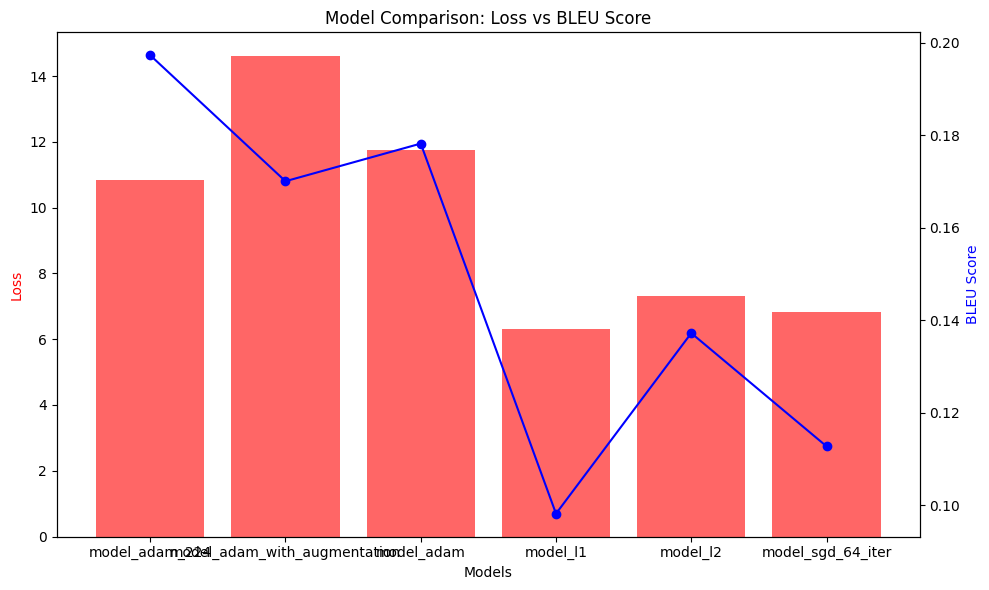

In [218]:
models_info={
    'model_adam_224':{'image_size':224,'augmentation':False},
    'model_adam_with_augmentation':{'image_size':224,'augmentation':True},
    'model_adam':{'image_size':256,'augmentation':False},
    'model_l1':{'image_size':224,'augmentation':False},
    'model_l2':{'image_size':224,'augmentation':False},
    'model_sgd_64_iter':{'image_size':224,'augmentation':False}
}
compare_models(models_info)

In [219]:

root="Flickr8k/Images/"
captions="Flickr8k/captions.txt"
dataset=FlickrDataset(root,captions,transform)
dataloader=DataLoader(dataset,batch_size=32,shuffle=False,collate_fn=MyCollate(dataset.vocab.stoi["<PAD>"]))
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
model=CNNtoRNN(embed_size,hidden_size,vocab_size,num_layers)
model.load_state_dict(torch.load('model_adam_224.pth'))
device='cuda'
model.to(device)
print_examples(model,device,dataset)

/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/esun/Image_Captioner/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_24412/2490428567.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running on the beach beside the ocean . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a child in a blue shirt is playing on a playground . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue jacket is riding a yellow vehicle along a main road . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a sailboat in the water . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a group of people hiking in the mountains . <EOS>
